In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf

# Check for GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Device Name:", tf.test.gpu_device_name())


Num GPUs Available: 1
GPU Device Name: /device:GPU:0


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image

In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:00<00:00, 166MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [11]:
import shutil
import os
# Define your Google Drive path (where you want the dataset to be stored)
drive_path = "/content/drive/MyDrive/DL_Project/dataset_new"

# Ensure the directory exists
os.makedirs(drive_path, exist_ok=True)

# Move the dataset from KaggleHub cache to Google Drive
shutil.move('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1', drive_path)

print(f"Dataset moved to: {drive_path}")


Dataset moved to: /content/drive/MyDrive/DL_Project/dataset_new


In [12]:
# Set image dimensions for resizing
IMG_SIZE = 224  # Example size, adjust as needed
TRAIN_DIR = '/content/drive/MyDrive/DL_Project/dataset_new/1/Training'  # Path to your training directory
TEST_DIR = '/content/drive/MyDrive/DL_Project/dataset_new/1/Testing'  # Path to your testing directory

# Directory names for labels
class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


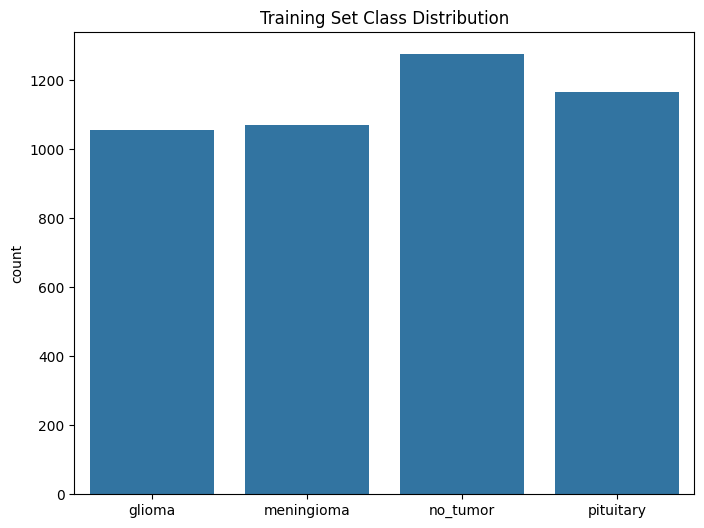

In [18]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Define your ImageDataGenerator for augmentation (same as before, but I've added validation_split)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of the data will be used for validation
)

# Use flow_from_directory for the training set
train_gen = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='training', # This is the training subset
    seed=42  # Important for reproducibility
)

# Use flow_from_directory for the validation set
validation_gen = datagen.flow_from_directory(
    TRAIN_DIR,  # Note: Same directory as training!
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='validation', # This is the validation subset
    seed=42
)

# Keep test_gen as it is (assuming TEST_DIR is a separate directory)
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(  # Important: No validation_split here
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical'
)

# Check the class distribution in the training set
train_labels = train_gen.classes
plt.figure(figsize=(8, 6))
sns.countplot(x=train_labels)
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.title('Training Set Class Distribution')
plt.show()

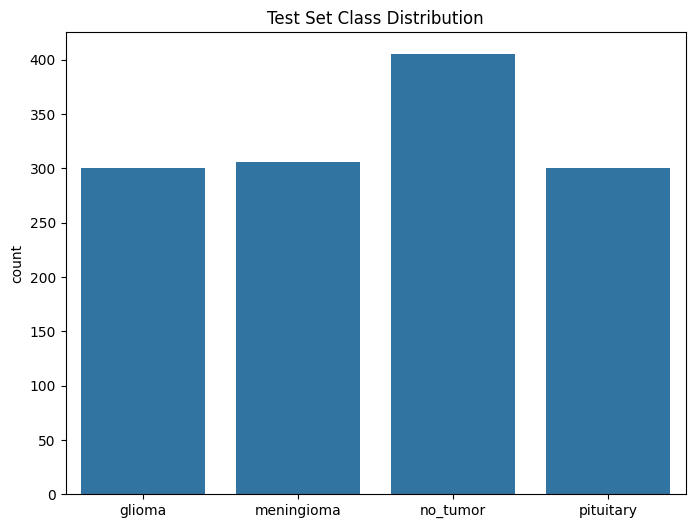

In [19]:
# Check the class distribution in the test set
test_labels = test_gen.classes
plt.figure(figsize=(8, 6))
sns.countplot(x=test_labels)
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.title('Test Set Class Distribution')
plt.show()


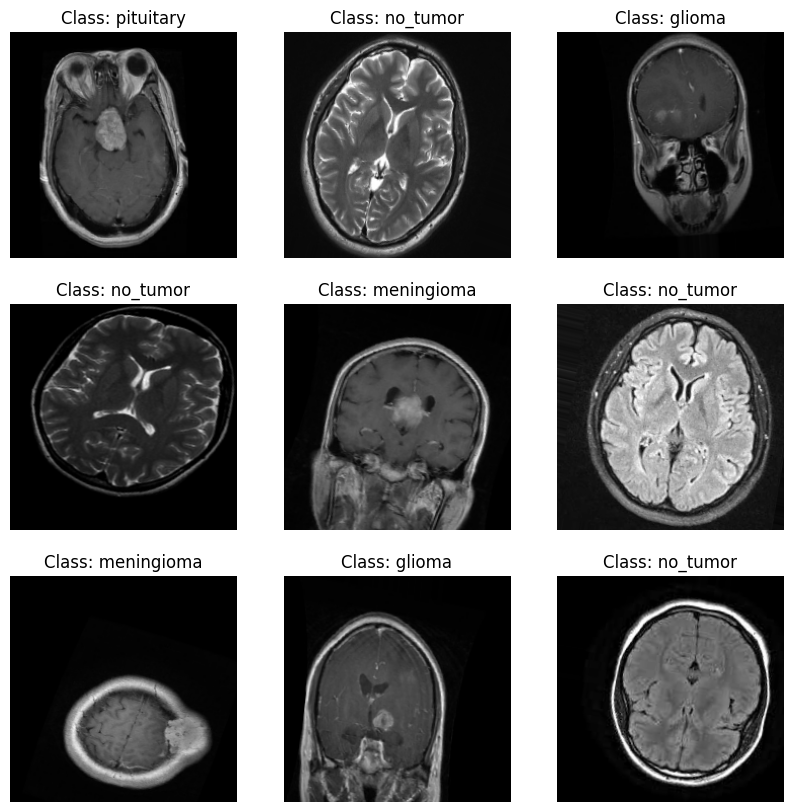

In [16]:
# Load a few sample images from the training set
sample_imgs, sample_labels = next(train_gen)  # Get a batch of images and labels
plt.figure(figsize=(10, 10))
for i in range(9):  # Show 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_imgs[i])  # The image is already normalized
    plt.title(f'Class: {class_names[np.argmax(sample_labels[i])]}')
    plt.axis('off')
plt.show()


In [20]:
# Compute class weights to address class imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.arange(len(class_names)),
    y=train_labels
)
class_weights_dict = dict(zip(np.arange(len(class_names)), class_weights))
print("Class weights:", class_weights_dict)


Class weights: {np.int64(0): np.float64(1.0811258278145695), np.int64(1): np.float64(1.0659981343283582), np.int64(2): np.float64(0.8955721003134797), np.int64(3): np.float64(0.9800600343053173)}


In [21]:
# Example: Create and compile a CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes for classification
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_gen, epochs=10, validation_data=validation_gen, class_weight=class_weights_dict)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 101s 659ms/step - accuracy: 0.3223 - loss: 1.9679 - val_accuracy: 0.5451 - val_loss: 1.1287
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 130s 611ms/step - accuracy: 0.5988 - loss: 0.9570 - val_accuracy: 0.6529 - val_loss: 0.9736
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 604ms/step - accuracy: 0.6893 - loss: 0.7864 - val_accuracy: 0.6897 - val_loss: 0.8478
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 88s 613ms/step - accuracy: 0.7206 - loss: 0.7157 - val_accuracy: 0.7073 - val_loss: 0.8763
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 604ms/step - accuracy: 0.7352 - loss: 0.6897 - val_accuracy: 0.6626 - val_loss: 0.8854
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 612ms/step - accuracy: 0.7268 - loss: 0.7112 - val_accuracy: 0.7029 - val_loss: 0.8606
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 606ms/step - accuracy: 0.7571 - loss: 0.6301 - val_accuracy: 0.7090 - val_loss: 0.7761
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 605ms/step - accuracy: 0.7566 - loss:

In [22]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.7671 - loss: 0.6160
Test Accuracy: 0.7674


In [23]:
model.save('/content/drive/MyDrive/DL_Project/models/brain_tumor_cnn.h5')


In [24]:
# from tensorflow.keras.models import load_model
# model = load_model('brain_tumor_cnn.h5')


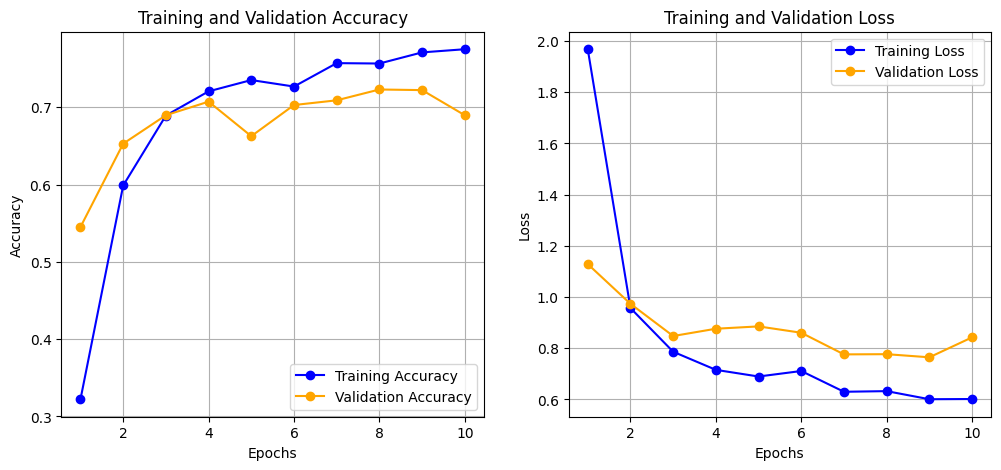

In [25]:
import matplotlib.pyplot as plt

# Training history values (extracted from logs)
epochs = list(range(1, 11))  # 10 epochs

train_accuracy = [0.3223, 0.5988, 0.6893, 0.7206, 0.7352, 0.7268, 0.7571, 0.7566, 0.7710, 0.7751]
val_accuracy = [0.5451, 0.6529, 0.6897, 0.7073, 0.6626, 0.7029, 0.7090, 0.7230, 0.7222, 0.6897]

train_loss = [1.9679, 0.9570, 0.7864, 0.7157, 0.6897, 0.7112, 0.6301, 0.6326, 0.6010, 0.6018]
val_loss = [1.1287, 0.9736, 0.8478, 0.8763, 0.8854, 0.8606, 0.7761, 0.7769, 0.7647, 0.8426]


# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, marker='o', label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracy, marker='o', label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, marker='o', label='Training Loss', color='blue')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()

plt.show()


In [26]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping



# Load DenseNet121 with pre-trained ImageNet weights, excluding the top classification layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model for transfer learning

# Add custom classifier layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)  # 4-class classification

# Create final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
history = model.fit(train_gen, validation_data=validation_gen, epochs=10, callbacks=[early_stopping])


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 148s 877ms/step - accuracy: 0.3324 - loss: 1.9164 - val_accuracy: 0.6223 - val_loss: 1.0204
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 628ms/step - accuracy: 0.5834 - loss: 1.0397 - val_accuracy: 0.6784 - val_loss: 0.9416
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 631ms/step - accuracy: 0.6549 - loss: 0.8592 - val_accuracy: 0.6933 - val_loss: 0.8921
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 631ms/step - accuracy: 0.7019 - loss: 0.7346 - val_accuracy: 0.7020 - val_loss: 0.8699
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 92s 644ms/step - accuracy: 0.7369 - loss: 0.6804 - val_accuracy: 0.7152 - val_loss: 0.8322
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 625ms/step - accuracy: 0.7437 - loss: 0.6448 - val_accuracy: 0.7082 - val_loss: 0.8357
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 143s 632ms/step - accuracy: 0.7513 - loss: 0.6438 - val_accuracy: 0.7222 - val_loss: 0.8129
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 623ms/step - accuracy: 0.7702 - loss:

In [29]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 458ms/step - accuracy: 0.7570 - loss: 0.6160
Test Accuracy: 0.7796


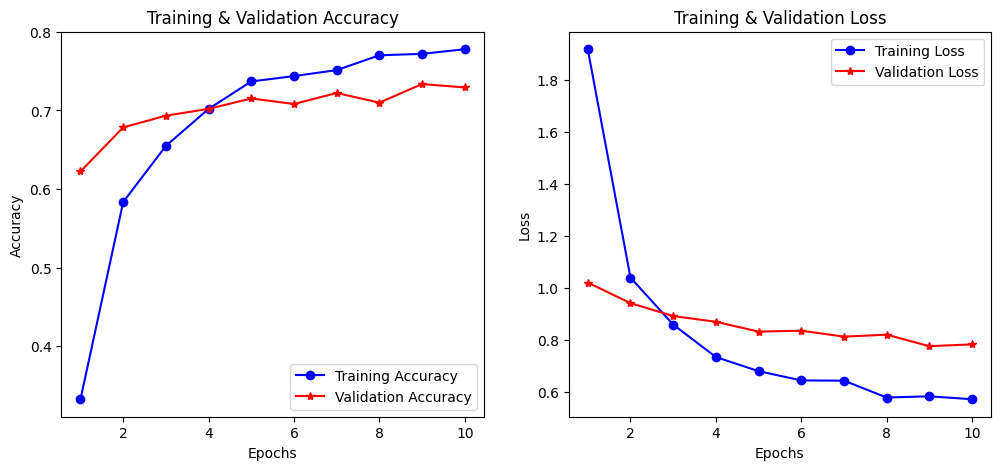

In [31]:
# Re-import required libraries since execution state was reset
import matplotlib.pyplot as plt

# Training history data
epochs = range(1, 11)


train_accuracy = [0.3324, 0.5834, 0.6549, 0.7019, 0.7369, 0.7437, 0.7513, 0.7702, 0.7720, 0.7779]
val_accuracy = [0.6223, 0.6784, 0.6933, 0.7020, 0.7152, 0.7082, 0.7222, 0.7099, 0.7336, 0.7292]

train_loss = [1.9164, 1.0397, 0.8592, 0.7346, 0.6804, 0.6448, 0.6438, 0.5792, 0.5837, 0.5726]
val_loss = [1.0204, 0.9416, 0.8921, 0.8699, 0.8322, 0.8357, 0.8129, 0.8204, 0.7762, 0.7832]


# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


In [32]:
# Save trained model
model.save('/content/drive/MyDrive/DL_Project/models/densenet_brain_tumor.h5')